# Chapter 13 - Beta and SML
---

In [9]:
# Preamble
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


def get_nzx(url):
    df = pd.read_html(url)[0]
    df.columns = df.columns.str.lower()
    lyst = ['price', 'volume', 'value', 'capitalisation', 'market capitalisation', 'percentage change', 'trade count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green bond']= df['green bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()
    return(df[df['market capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))

---

**Webscraping the NZX**

---

In [10]:
dfm, nzx  = get_nzx('https://www.nzx.com/markets/NZSX')

In [11]:
def closing_prics(nzx, start, end):
    dfy = yf.download(nzx, start, end, progress=True, interval="1mo")
    df_close = dfy['Adj Close'].copy()
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    #df_close.dropna(how='all').pct_change().add(1).cumprod().mean(axis=1).sub(1).plot()
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = closing_prics(nzx+['^NZ50'], '2017-03-31', '2022-04-30')
#nzx_set, df_close = returns(nzx+['^NZ50'], '2015-01-01', '2019-12-30')

[*********************100%***********************]  154 of 154 completed

11 Failed downloads:
- FCT.NZ: No data found for this date range, symbol may be delisted
- BRMWG.NZ: No data found, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted
- ALD.NZ: No data found, symbol may be delisted
- NTLOB.NZ: No data found, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- JPG.NZ: No data found for this date range, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted


In [12]:
df_close.sample(5)

,ACE,AFC,AFI,AFT,AGL,AIA,AIR,ALF,ANZ,APL,...,VGL,VHP,VNT,VSL,VTL,WBC,WDT,WHS,WIN,NZ50
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-30,0.1,0.001,6.702017,4.63,1.424762,7.270000,1.550000,0.620000,29.643301,0.311524,...,2.390000,3.025254,NaN,NaN,0.825714,27.131670,0.093000,3.323321,NaN,12654.599609
2018-07-31,0.3,0.001,6.268530,2.35,1.556570,6.264068,2.720846,0.689843,27.705416,0.488822,...,3.928571,1.879530,NaN,NaN,0.820019,27.512655,0.162990,1.584386,NaN,8922.089844
2018-11-30,0.4,0.001,6.397588,2.20,1.354941,6.859833,2.670584,0.596160,24.880993,0.487733,...,3.408808,1.903900,NaN,NaN,0.655749,23.880848,0.158333,1.662820,NaN,8823.540039
2020-10-31,0.2,0.001,6.605446,5.00,1.378802,7.000000,1.420000,0.558449,19.258789,0.284927,...,1.510000,2.802243,NaN,NaN,0.734892,17.951622,0.066000,2.177959,NaN,12084.469727
2018-06-30,0.3,0.001,6.268530,2.40,1.555608,6.362605,2.662154,0.596160,26.931959,0.473206,...,3.582483,1.767838,NaN,NaN,0.828933,27.495523,0.139705,1.615759,NaN,8943.129883


---

**Obtain list of share prices and calculate returns**

---

<AxesSubplot:xlabel='Date'>

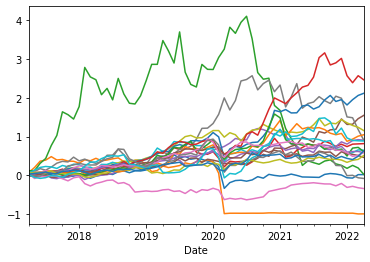

In [13]:
market = 'NZ50'
stocks_list = ["AIR", "FPH", "MEL", "AIA", "SPK", "MCY", "MFT", "EBO", "CEN", "IFT", "FBU", "RYM", "POT", "VCT", "ATM", "CNU", "GMT", "GNE", "SUM", "PCT", "NZ50"]
stocks_list.sort()
data = df_close[stocks_list]
data.sample(5)
# Calculate monthly returns
day_ret = np.log(data).diff().dropna()
day_ret.add(1).cumprod().sub(1).plot(legend=False)

---

**Loading Benninga's data**

---

In [6]:
day_ret = pd.read_csv('Chapt13_ret_data.csv')
day_ret['Date'] =  pd.to_datetime(day_ret['Date'])
day_ret.set_index('Date', inplace=True)
day_ret.head(5)
market = "GSPC"

**The following prepares the data in such a way that we can run regressions per firm.**

- It separates out the index,
- Then it melts the data into a long single column,
- After which it matches the returns per day,
- The output is a panel with $ri$ and $rm$.


In [14]:
def shape_data(day_ret, idxvar, idxcolumn):
    # make sure we have the right data
    if idxvar in list(day_ret):
        print("Right source")
        if isinstance(idxcolumn, pd.Series):   
            dfi = idxcolumn
            print("Series")    
        else: 
            dfi = day_ret[[idxvar]] 
            print("Label, market: "+ idxvar)    
    else:
        print("Wrong source")
        return
    df = (day_ret[[x for x in list(day_ret) if x!=idxvar]]
          .copy()
          .reset_index()
          .melt(id_vars=['Date']).set_index('Date')
          .join(dfi)
          .reset_index()
          .sort_values(by=['variable', 'Date'])
          .set_index('variable')
          .sort_index()
          .rename(columns={'value': 'ri', idxvar: 'rm', 'prop_return': 'beta'})
          )
    return df

In [15]:
#df = shape_data(day_ret, market, "")
df = shape_data(day_ret, 'NZ50', "")
df.head(3)

Right source
Label, market: NZ50


,Date,ri,rm
variable,,,
AIA,2017-04-30,0.034764,0.024971
AIA,2017-05-31,0.012959,0.005427
AIA,2017-06-30,0.019831,0.025622


**The function below runs a regression on two columns of a frame**

In [16]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

**Running the first pass regression**

In [17]:
dfb = df.groupby('variable').apply(regress, 'ri', ['rm'])
dfb.T

variable,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
rm,1.467663,2.964168,0.989172,1.027775,0.395943,0.377075,1.614433,0.732419,0.457470,1.216526,1.076473,0.971362,1.401019,1.022384,0.559687,0.586149,2.129031,0.519506,1.618258,0.592999
intercept,-0.007817,-0.036489,0.000031,0.003473,0.008878,0.013578,-0.014583,0.008038,0.009621,0.000260,0.011887,0.005558,-0.001175,0.013805,0.002316,0.004053,-0.014544,0.003444,0.001536,0.004142


**Second pass regression needs the mean returns**

In [18]:
dfr = df['ri'].groupby('variable').mean()
dfr.to_frame().T

variable,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
ri,0.004251,-0.012116,0.008165,0.011924,0.012133,0.016678,-0.001308,0.014061,0.013382,0.010263,0.020739,0.013546,0.010345,0.022212,0.006918,0.008873,0.002962,0.007716,0.014843,0.009018


**Second pass regression needs the mean returns, combined with the betas**

In [19]:
dfb = dfb['rm'].to_frame().join(dfr)
dfb.rename(columns = {'rm': 'beta'}, inplace=True)
dfb.T

variable,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
beta,1.467663,2.964168,0.989172,1.027775,0.395943,0.377075,1.614433,0.732419,0.457470,1.216526,1.076473,0.971362,1.401019,1.022384,0.559687,0.586149,2.129031,0.519506,1.618258,0.592999
ri,0.004251,-0.012116,0.008165,0.011924,0.012133,0.016678,-0.001308,0.014061,0.013382,0.010263,0.020739,0.013546,0.010345,0.022212,0.006918,0.008873,0.002962,0.007716,0.014843,0.009018


### Plotting the second pass regression: ###

In [20]:
def scattplot(X, Y, returns):
    def plotlabel(beta, ri, variable):
        ax.text(beta+0.005, ri, variable)
    results = smf.ols(Y + ' ~ 1 + ' + X, data=returns).fit()
    fig = plt.figure(figsize=(10,10))
    ax = sns.regplot(x=X, y=Y, data=returns, scatter_kws={'s':5})
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Monthly Returns')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    # Equation
    plusmin = '-' if results.params.Intercept<0 else '+'
    equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    ax.text(y = returns[Y].max(), x = returns[X].min(), s = equation)
    
    dfc = dfb.reset_index()
    dfc.apply(lambda x: plotlabel(x['beta'],  x['ri'], x['variable']), axis=1)
    plt.show()
    print(results.summary())
    return


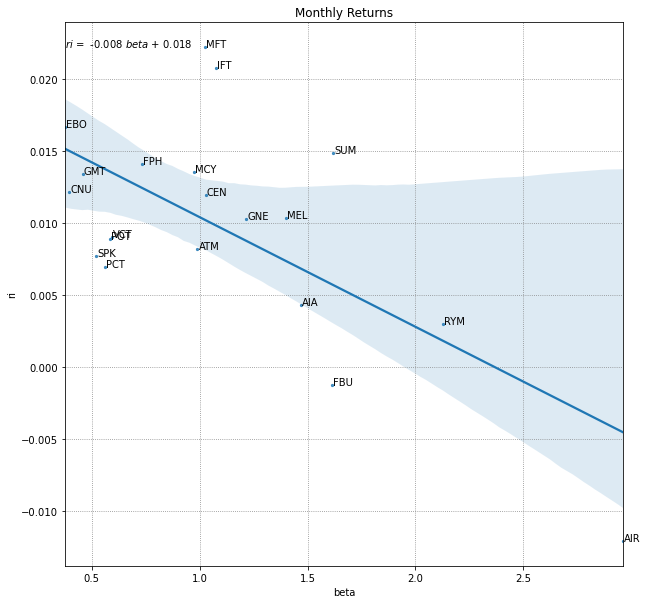

                            OLS Regression Results                            
Dep. Variable:                     ri   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     13.28
Date:                Tue, 17 May 2022   Prob (F-statistic):            0.00185
Time:                        20:47:26   Log-Likelihood:                 75.232
No. Observations:                  20   AIC:                            -146.5
Df Residuals:                      18   BIC:                            -144.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0180      0.003      6.850      0.0

In [21]:
scattplot('beta','ri', dfb)

### The Non-Efficiency of the "Market Portfolio" ###
**Calculate Envelope Portfolio proportions in one step (FROM CHAPTER 11)***

**First calculate return vector**

In [22]:
idxvar = market
lyst = [x for x in list(day_ret) if x!=idxvar]
dfs = day_ret[lyst].cov()              
dfr = day_ret[lyst].mean()
dfr.name= 'Returns'
dfr.to_frame().T

,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
Returns,0.004251,-0.012116,0.008165,0.011924,0.012133,0.016678,-0.001308,0.014061,0.013382,0.010263,0.020739,0.013546,0.010345,0.022212,0.006918,0.008873,0.002962,0.007716,0.014843,0.009018


### Function: Calculate Envelope Portfolio proportions in one step ###
**See also this link from [Auke Plantinga](https://www.youtube.com/watch?v=OGhGz8trZtw)**

The function relies on the Sharpe ratio, see appendix to Chapter 11. 



<AxesSubplot:title={'center':'Proportions'}>

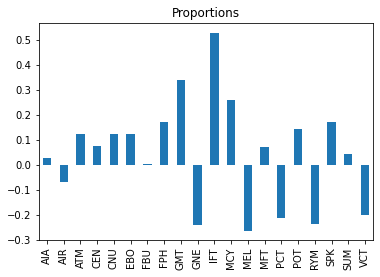

In [23]:
def envelope_portfolio_df(dfs, dfr, constant):
    df_inv = pd.DataFrame(np.linalg.pinv(dfs.values), dfs.columns, dfs.columns)
    ex_ret = dfr - constant
    Z = df_inv @ ex_ret
    return Z/Z.sum() # Efficient Portfolio proportions
port_v_prop = envelope_portfolio_df(dfs, dfr, 0.0006432)
port_v_prop.to_frame().T
port_v_prop.plot(kind = 'bar', title = "Proportions")

In [24]:
port_v_ret = day_ret[lyst] @ port_v_prop   # Returns n dates x k firms @ k firms x 1 = weighted returns per date
port_v_ret.name = "prop_return"
port_v_var = port_v_prop @ dfs @ port_v_prop # Portfolio variances and covariances
port_v_sigma = port_v_var**.5

**Weighted returns, efficient portfolio returns, per date:**

In [25]:
port_v_ret.to_frame().T

Date,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,...,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30
prop_return,0.036936,0.023024,-0.008003,0.041779,0.029042,0.02227,0.057213,-0.012618,0.037239,0.009644,...,-0.012076,0.045382,0.029939,-0.004978,0.073718,0.025055,-0.027863,-0.010011,0.053067,-0.013081


**Efficient portfolio returns per date combined with efficient portfolio returns**

In [26]:
df = shape_data(day_ret, market, port_v_ret)
print(df.head(3))
print(df.shape)

Right source
Series
               Date        ri      beta
variable                               
AIA      2017-04-30  0.034764  0.036936
AIA      2017-05-31  0.012959  0.023024
AIA      2017-06-30  0.019831 -0.008003
(1220, 3)


**Running the first pass regression**

In [27]:
dfb = df.groupby('variable').apply(regress, 'ri', ['beta'])
dfb.T

variable,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
beta,0.156784,-0.554464,0.326853,0.490214,0.499323,0.696830,-0.084777,0.583082,0.553600,0.418046,0.873281,0.560696,0.421597,0.937318,0.272695,0.357642,0.100772,0.307370,0.617068,0.363947
intercept,0.000542,0.001000,0.000433,0.000328,0.000322,0.000195,0.000698,0.000268,0.000287,0.000374,0.000082,0.000283,0.000372,0.000040,0.000468,0.000413,0.000578,0.000445,0.000246,0.000409


**Second pass regression needs the mean returns**

In [28]:
dfr = df['ri'].groupby('variable').mean()
dfr.to_frame().T

variable,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
ri,0.004251,-0.012116,0.008165,0.011924,0.012133,0.016678,-0.001308,0.014061,0.013382,0.010263,0.020739,0.013546,0.010345,0.022212,0.006918,0.008873,0.002962,0.007716,0.014843,0.009018


**Second pass regression needs the mean returns, combined with the betas**

In [29]:
dfb = dfb['beta'].to_frame().join(dfr)
dfb.T

variable,AIA,AIR,ATM,CEN,CNU,EBO,FBU,FPH,GMT,GNE,IFT,MCY,MEL,MFT,PCT,POT,RYM,SPK,SUM,VCT
beta,0.156784,-0.554464,0.326853,0.490214,0.499323,0.696830,-0.084777,0.583082,0.553600,0.418046,0.873281,0.560696,0.421597,0.937318,0.272695,0.357642,0.100772,0.307370,0.617068,0.363947
ri,0.004251,-0.012116,0.008165,0.011924,0.012133,0.016678,-0.001308,0.014061,0.013382,0.010263,0.020739,0.013546,0.010345,0.022212,0.006918,0.008873,0.002962,0.007716,0.014843,0.009018


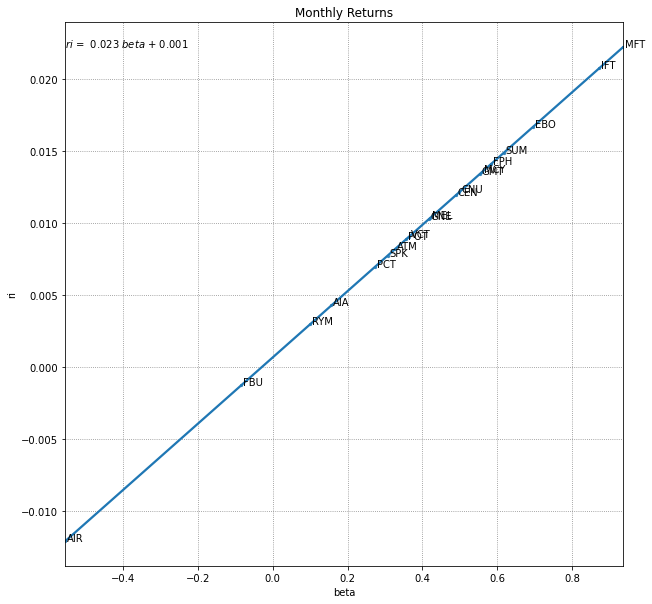

                            OLS Regression Results                            
Dep. Variable:                     ri   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.868e+29
Date:                Tue, 17 May 2022   Prob (F-statistic):          4.46e-258
Time:                        20:47:27   Log-Likelihood:                 726.24
No. Observations:                  20   AIC:                            -1448.
Df Residuals:                      18   BIC:                            -1446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006   1.53e-17    4.2e+13      0.0

In [30]:
scattplot('beta','ri', dfb)